In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import random
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [2]:
# For data cleaning
import HTMLParser

In [7]:
data = pd.read_excel('text.xlsx','Sheet1')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 4 columns):
Row        2496 non-null int64
Remark     2494 non-null object
Reason     2496 non-null object
Con_Ord    2496 non-null object
dtypes: int64(1), object(3)
memory usage: 78.1+ KB


In [9]:
data['Reason'] = data.Reason.apply(lambda x: x.lower())

In [10]:
#data.Remark.value_counts()

### 1. Escaping HTML characters
* HTML cleaning. &lt; is converted to “<” and &amp; is converted to “&” etc.

In [11]:
html_parser = HTMLParser.HTMLParser()
data['Remark'] = data['Remark'].apply(lambda x: html_parser.unescape(str(x)))

### 2. Decoding data
* Text data may be subject to different forms of decoding like “Latin”, “UTF8” etc. Therefore, for better analysis, it is necessary to keep the complete data in standard encoding format. UTF-8 encoding is widely accepted and is recommended to use.

In [12]:
data['Remark'] = data['Remark'].apply(lambda x: str(x).decode("utf8").encode('ascii','ignore'))

### 3. Lower Word conversion

In [13]:
# Convert remarks to lower
data['Remark'] = data.Remark.str.lower()

### 4. Punctuation Removal

In [14]:
import string

data['Remark'] = data.Remark.apply(lambda x: re.sub('['+string.punctuation+']', ' ', x))

### 5. Stop Word Removal

In [15]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [16]:
data['Remark'] = data['Remark'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stop]))

### 6. Improving Spellings

In [17]:
# This function replaces repetition (more than 2). Eg: finallllllly -> finally
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)


In [18]:
data['Remark'] = data['Remark'].apply(lambda x: ' '.join([reduce_lengthening(i) for i in x.split(' ')]))

### 7. Visualize

In [19]:
#Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

def cleaner(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [lmtzr.lemmatize(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i
data['Remark'] = data.Remark.apply(lambda x: cleaner(x))

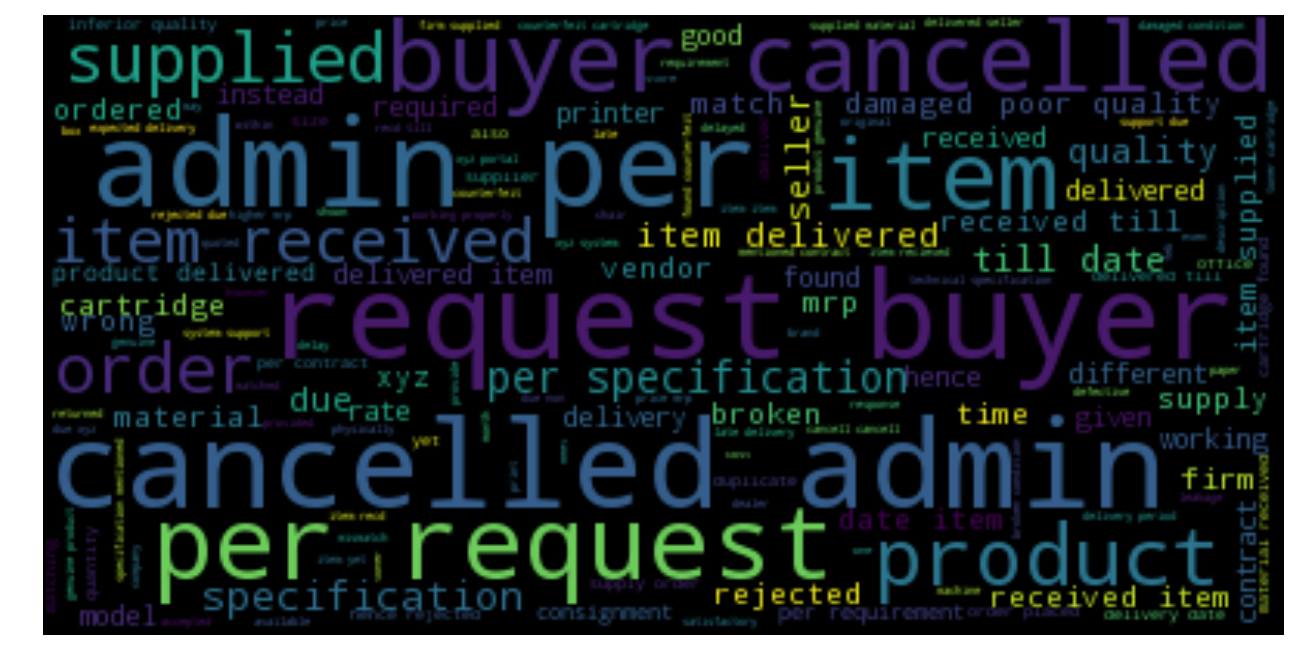

In [20]:
wordcloud = WordCloud(max_font_size=40).generate(' '.join(data['Remark']))
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
# Labels
data.Reason.value_counts()

delayed/no  delivery                               663
item supplied were not as per the specification    566
damaged/not working/defective/poor quality         414
duplicate/fake                                     279
cancelled by admin as per request by buyer         235
other                                              182
price higher than mrp/lesst than 10% discount      100
wrongly placed by buyer                             42
due to xyz system not support                       15
Name: Reason, dtype: int64

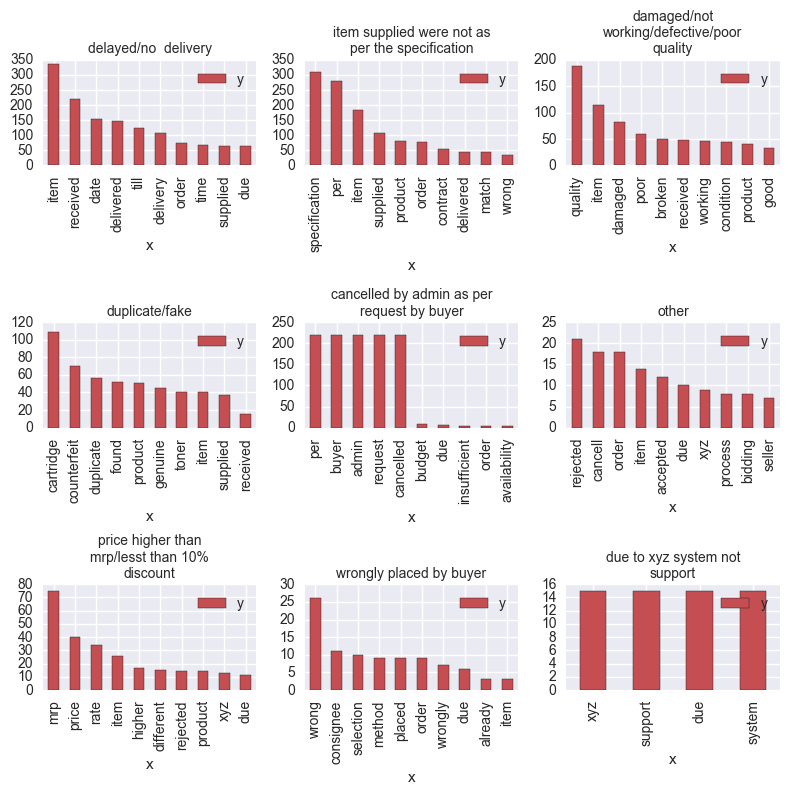

In [22]:
from nltk import FreqDist 
#Freq of words with respect to lables
from textwrap import wrap
d = {}

for i in list(data.Reason.value_counts().index):
    df = data[data['Reason']==i]
    frq = FreqDist(' '.join(df.Remark).split())
    frqq = frq.most_common(10)
    d[i] = frqq

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(8,8))
i=0
j=0
reasons = list(data.Reason.value_counts().index)
for reason in reasons:
    pl = pd.DataFrame({'x':[w[0] for w in d[reason]],'y' : [w[1] for w in d[reason]]})
    ax = pl.plot(x = 'x',y='y',kind='bar',ax=axes[reasons.index(reason)/3,reasons.index(reason)%3],color = 'r')
    ax.set_title("\n".join(wrap(reason,25)),fontsize=10)
fig.tight_layout()    


### 7. Stemming

In [23]:
from nltk.stem import PorterStemmer

In [24]:
# Removes symbols, numbers and stem the words to reduce dimentional space
stemmer = PorterStemmer()


def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i

In [25]:
data['Remark'] = data.Remark.apply(lambda x: clean(x))

### 8. Split and Create feat

In [26]:
train=data.sample(frac=0.7,random_state=200)
test=data.drop(train.index)

In [27]:
# Create feat using most freq words for each class
from nltk import FreqDist
d={}
for i in list(train.Reason.value_counts().index):
    df = train[train['Reason']==i]
    frq = FreqDist(' '.join(df.Remark).split())
    frqq = frq.most_common(10)
    d[i] = frqq

feat = []
for i in d.values():
    for j in i:
        feat.append(j[0])

feat = list(set(feat))

In [28]:
for f in feat:
    train[f] = train.Remark.apply(lambda x: 1 if f in x else 0)
    test[f] = test.Remark.apply(lambda x: 1 if f in x else 0)

In [29]:
train['len'] = train.Reason.apply(lambda x: len(x))
test['len'] = test.Reason.apply(lambda x: len(x))

In [30]:
feat.append('len')
len(feat)

58

In [31]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score

In [32]:
#feat.remove('len')

In [33]:
model = RF()
model.fit(train[feat],train['Reason'])
np.mean(cross_val_score(model,train[feat],train['Reason'],cv = 3))

0.99141176046635104

In [34]:
test['pred'] = model.predict(test[feat])

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(test['Reason'],test['pred'])

0.99065420560747663

In [36]:
imp = model.feature_importances_

In [37]:
features = feat
df = pd.DataFrame({'words':features,'imp':imp}).sort_values(by='imp',ascending=False).head(30)

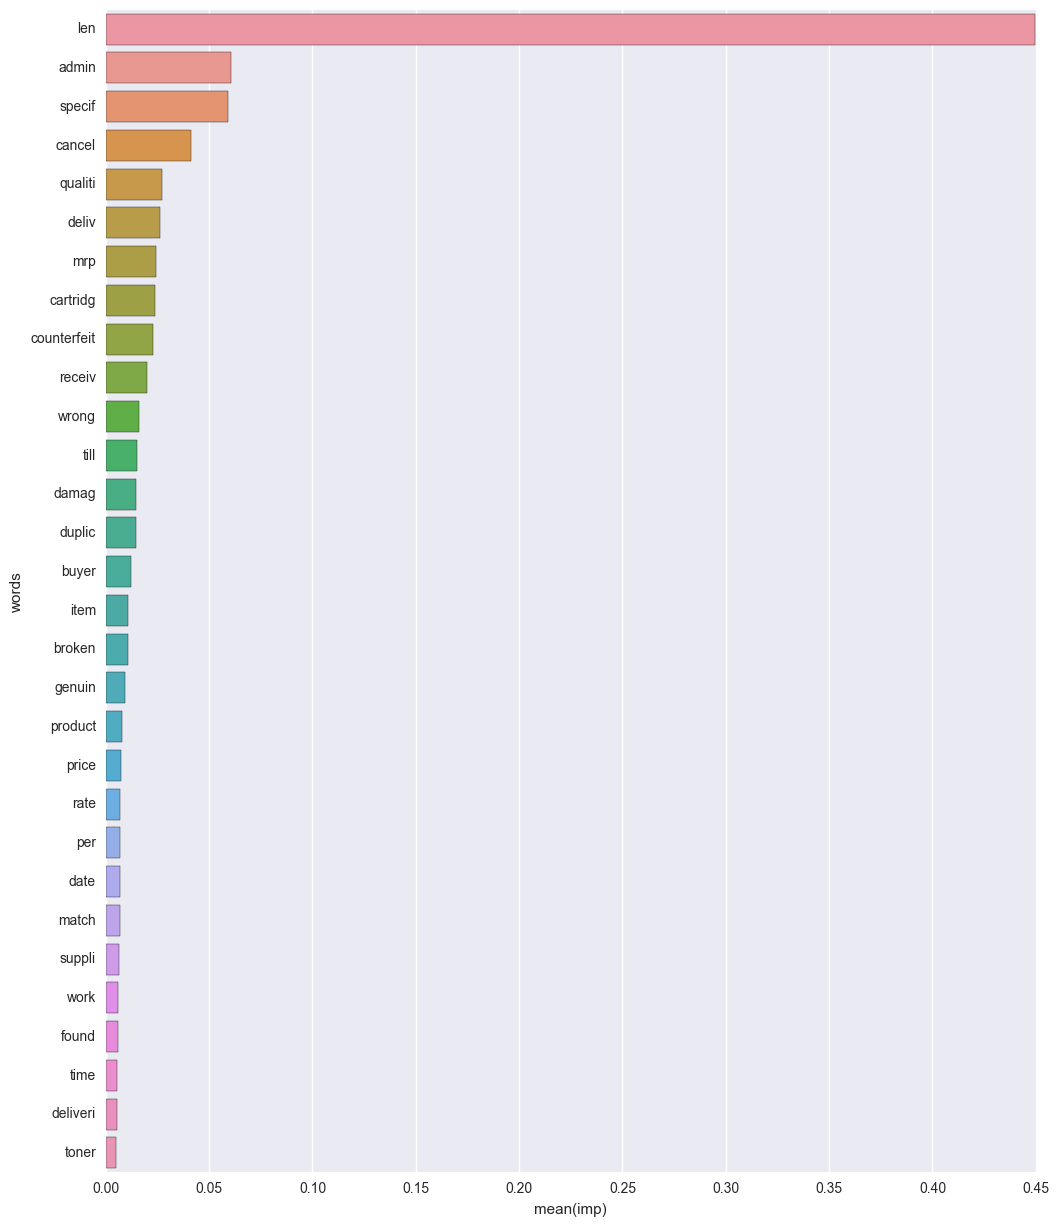

In [38]:
plt.figure(figsize=(12,15))
sns.barplot(y=df.words,x=df.imp)

In [39]:
train[['Reason','len']].groupby('Reason').mean()

,len
Reason,
cancelled by admin as per request by buyer,42
damaged/not working/defective/poor quality,42
delayed/no delivery,20
due to xyz system not support,29
duplicate/fake,14
item supplied were not as per the specification,47
other,5
price higher than mrp/lesst than 10% discount,45
wrongly placed by buyer,23


### Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix
conf_arr = confusion_matrix(test['Reason'],test['pred'])

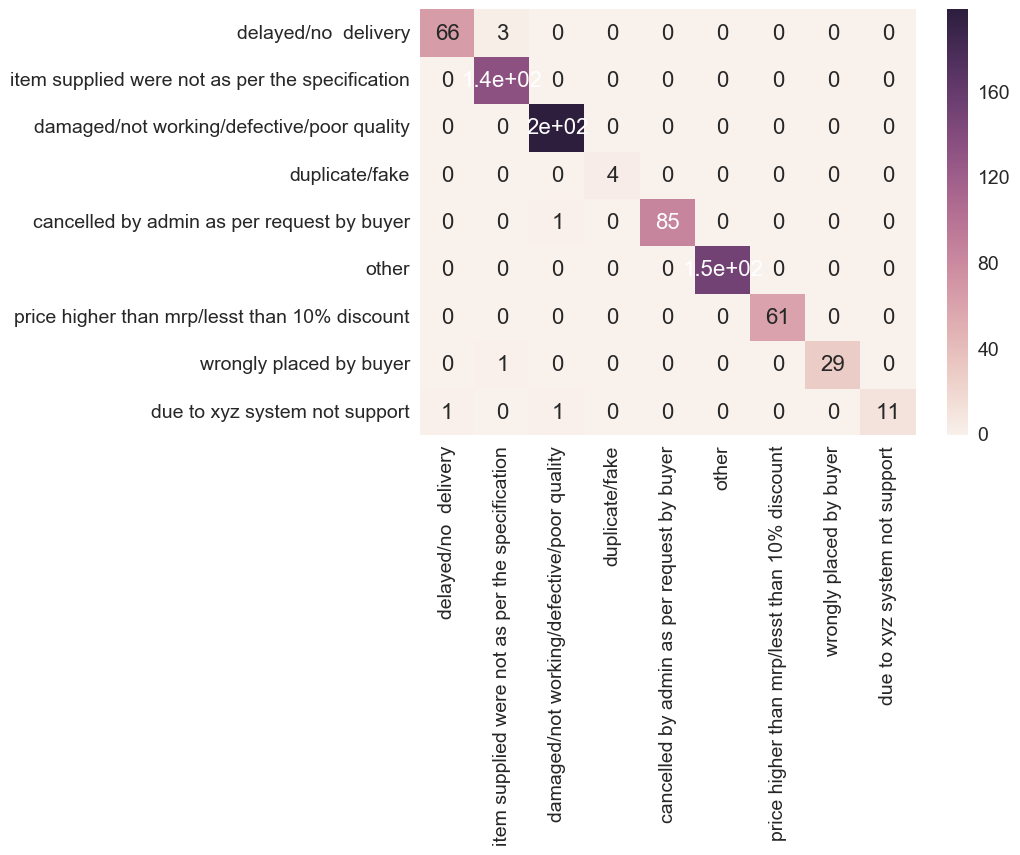

In [41]:
import seaborn as sn
df_cm = pd.DataFrame(conf_arr, list(train.Reason.value_counts().index),
                  list(train.Reason.value_counts().index))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [42]:
pd.crosstab(test['Reason'],test['pred'], rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,cancelled by admin as per request by buyer,damaged/not working/defective/poor quality,delayed/no delivery,due to xyz system not support,duplicate/fake,item supplied were not as per the specification,other,price higher than mrp/lesst than 10% discount,wrongly placed by buyer,All
Actual,,,,,,,,,,
cancelled by admin as per request by buyer,66,3,0,0,0,0,0,0,0,69
damaged/not working/defective/poor quality,0,135,0,0,0,0,0,0,0,135
delayed/no delivery,0,0,199,0,0,0,0,0,0,199
due to xyz system not support,0,0,0,4,0,0,0,0,0,4
duplicate/fake,0,0,1,0,85,0,0,0,0,86
item supplied were not as per the specification,0,0,0,0,0,152,0,0,0,152
other,0,0,0,0,0,0,61,0,0,61
price higher than mrp/lesst than 10% discount,0,1,0,0,0,0,0,29,0,30
wrongly placed by buyer,1,0,1,0,0,0,0,0,11,13
